In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import mlflow, os
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

from model_utils import get_pipeline
from mlFlow.MLflowTracker import MLflowTracker
from model_utils import run_training_with_mlflow
from data_prep import reduce_mem_usage


In [2]:
target = "TARGET"
train = reduce_mem_usage(pd.read_csv("../model/application_train_enriched.csv"))
test = reduce_mem_usage(pd.read_csv("../model/application_test_enriched.csv"))

Usage mémoire initial du DataFrame: 612.34 MB
Usage mémoire final du DataFrame: 211.44 MB
Mémoire réduite de 65.5 %
Usage mémoire initial du DataFrame: 121.24 MB
Usage mémoire final du DataFrame: 43.32 MB
Mémoire réduite de 64.3 %


In [3]:
# size of train and test
print(f"Train size: {train.shape}")

ones = train[train[target] == 1]
zeros = train[train[target] == 0].sample(n=len(ones)*3, random_state=42)
train = pd.concat([ones, zeros], axis=0).reset_index(drop=True)
print(f"Train size after balancing: {train.shape}")

Train size: (307511, 261)
Train size after balancing: (99300, 261)


In [4]:
X = train.drop(columns=[target])
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [5]:
number_col = X_train.select_dtypes(include=np.number).columns
print(f"{number_col=}")
categorical_col = X_train.select_dtypes(include=['object']).columns
print(f"{categorical_col=}")

number_col=Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'DAYS_INSTALMENT_mean', 'DAYS_ENTRY_PAYMENT_min',
       'DAYS_ENTRY_PAYMENT_max', 'DAYS_ENTRY_PAYMENT_mean',
       'CNT_INSTALMENT_sum', 'CNT_INSTALMENT_mean', 'SK_DPD_max_y',
       'SK_DPD_mean_y', 'SK_DPD_DEF_max_y', 'SK_DPD_DEF_mean_y'],
      dtype='object', length=245)
categorical_col=Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


In [6]:
param_grid = {
    "model__n_estimators": [100, 200],
   #"model__max_depth": [10, 20],
   #"model__min_samples_split": [2, 5],
   #"model__min_samples_leaf": [1, 2],
   #"model__max_features": ["sqrt", "log2"],
   # "model__class_weight": ['balanced', {0: 1, 1: 10}]
}

In [7]:
pipeline = get_pipeline(RandomForestClassifier(), numeric_features=number_col, categorical_features=categorical_col)
grid = GridSearchCV(pipeline, param_grid, cv=skf, n_jobs=-1, verbose=2)

In [8]:
tracker = MLflowTracker("home_credit_experiment")

2025/12/14 00:49:06 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/14 00:49:06 INFO mlflow.store.db.utils: Updating database tables
2025-12-14 00:49:06 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-12-14 00:49:06 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-12-14 00:49:06 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-12-14 00:49:06 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


[MLflow] L'expérience existante 'home_credit_experiment' a un artifact_location différent.
Création et basculement vers la nouvelle expérience 'home_credit_experiment_20251214_004906' avec artifact_location=file:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1%20Cours/S7/Majeur%20Projets/Project%20DEA/model.
[MLflow] Tracking sur: sqlite:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1 Cours/S7/Majeur Projets/Project DEA/mlruns/mlflow.db ; artefacts -> file:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1%20Cours/S7/Majeur%20Projets/Project%20DEA/model


In [9]:
best_model, metrics = run_training_with_mlflow(
    grid=grid,
    pipeline=pipeline,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    tracker=tracker,
    run_name="rf_gridsearch_v1",
    model_name="home_credit_rf"
)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


2025/12/14 00:52:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/14 00:52:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/14 00:52:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/14 00:52:06 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/14 00:52:06 INFO mlflow.store.db.utils: Updating database tables
2025-12-14 00:52:06 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-12-14 00:52:06 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Registered model 'home_credit_rf' already exists. Creating a new version of this model...
2025/12/14 00:52:06 WARNING mlflow.tracking._model_registry.fluent: Run with id 07618de807224a8591

[MLflow] Enregistrement du modèle : runs:/07618de807224a85918af6aa4bbc1bfe/model

=== Résultats ===
Best params: {'model__n_estimators': 200}
{'train_accuracy': 1.0, 'test_accuracy': 0.7619335347432025, 'train_AUC': 1.0, 'test_AUC': 0.547133444180584, 'train_f1': 1.0, 'test_f1': 0.19564477713507997}
Registered version: 4


Created version '4' of model 'home_credit_rf'.


In [10]:
y_pred = grid.predict(X_test)
print("Best parameters:")
print(grid.best_params_)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

Best parameters:
{'model__n_estimators': 200}
Accuracy : 0.7619335347432025
F1 Score : 0.6932265541055642
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     14868
           1       0.65      0.12      0.20      4992

    accuracy                           0.76     19860
   macro avg       0.71      0.55      0.53     19860
weighted avg       0.74      0.76      0.69     19860



In [11]:
confusion_matrix(y_test, y_pred)

array([[14557,   311],
       [ 4417,   575]])

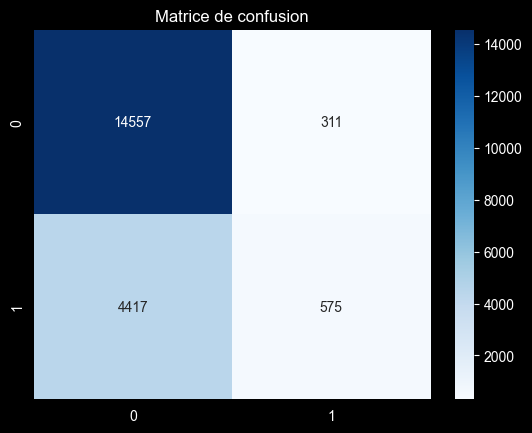

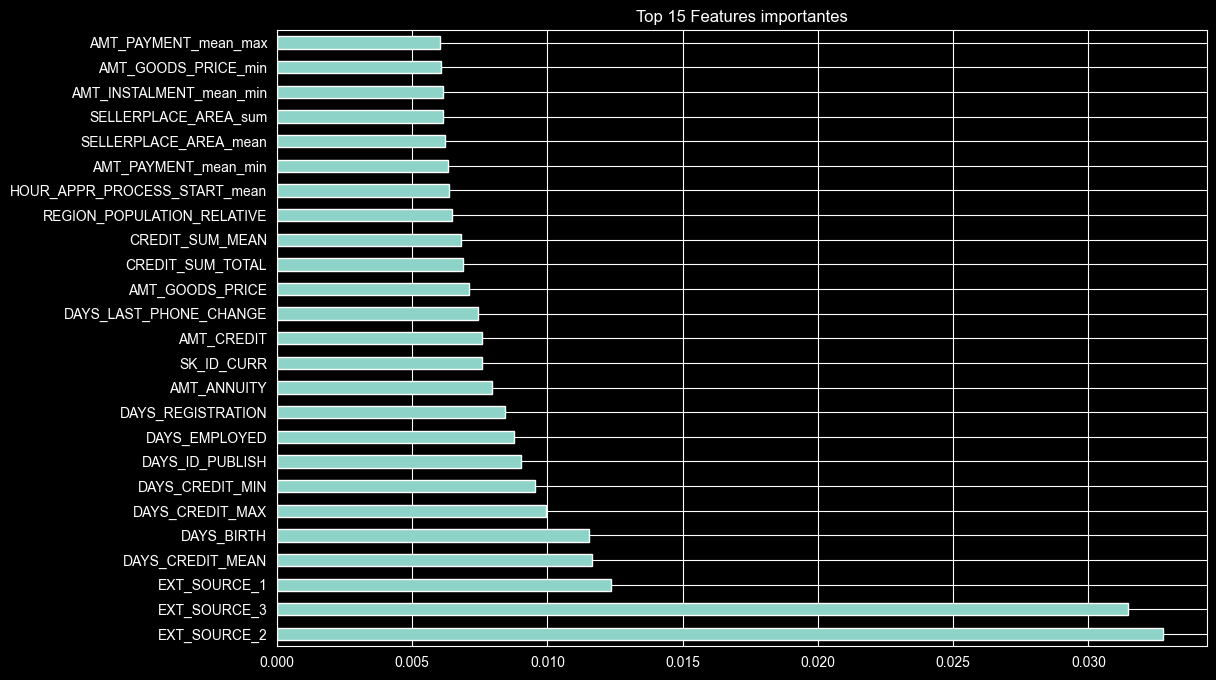

In [12]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.show()
model = grid.best_estimator_.named_steps["model"]
preprocessor = grid.best_estimator_.named_steps["preprocessing"]
feature_names = preprocessor.get_feature_names_out()
clean_names = [name.split("__")[-1] for name in feature_names]
importances = pd.Series(model.feature_importances_, index=clean_names)
importances.sort_values(ascending=False).head(25).plot(kind="barh", figsize=(12, 8))
plt.title("Top 15 Features importantes")
plt.show()

# Logistic Regression Model

In [13]:
param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__solver": ['liblinear', 'saga'],
    "model__max_iter": [200],
    "model__class_weight": ['balanced', {0: 1, 1: 10}]
}
pipeline = get_pipeline(LogisticRegression(), numeric_features=number_col, categorical_features=categorical_col)
grid = GridSearchCV(pipeline, param_grid, cv=skf, n_jobs=-1, verbose=2)
tracker = MLflowTracker("home_credit_experiment")

best_model, metrics = run_training_with_mlflow(
    grid=grid,
    pipeline=pipeline,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    tracker=tracker,
    run_name="logreg_gridsearch_v1",
    model_name="home_credit_logreg"
)

[MLflow] L'expérience existante 'home_credit_experiment' a un artifact_location différent.
Création et basculement vers la nouvelle expérience 'home_credit_experiment_20251214_005207' avec artifact_location=file:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1%20Cours/S7/Majeur%20Projets/Project%20DEA/model.
[MLflow] Tracking sur: sqlite:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1 Cours/S7/Majeur Projets/Project DEA/mlruns/mlflow.db ; artefacts -> file:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1%20Cours/S7/Majeur%20Projets/Project%20DEA/model
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025/12/14 00:56:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/14 00:56:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/14 00:56:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'home_credit_logreg' already exists. Creating a new version of this model...
2025/12/14 00:56:24 WARNING mlflow.tracking._model_registry.fluent: Run with id 9b625c3db3dc48eaa879507d3a7bcd8b has no artifacts at artifact path 'model', registering model based on models:/m-8577aaf8394146c6b6a9a63efd79ed40 instead


[MLflow] Enregistrement du modèle : runs:/9b625c3db3dc48eaa879507d3a7bcd8b/model

=== Résultats ===
Best params: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__max_iter': 200, 'model__solver': 'liblinear'}
{'train_accuracy': 0.7053121852970795, 'test_accuracy': 0.698539778449144, 'train_AUC': 0.7043288153449059, 'test_AUC': 0.6947401556776557, 'train_f1': 0.5433976984591379, 'test_f1': 0.5339768039230949}
Registered version: 2


Created version '2' of model 'home_credit_logreg'.


# LightGBM

In [14]:
param_grid = {
    "model__class_weight": ['balanced', {0: 1, 1: 10}]
}
from lightgbm import LGBMClassifier
pipeline = get_pipeline(LGBMClassifier(), numeric_features=number_col, categorical_features=categorical_col)
grid = GridSearchCV(pipeline, param_grid, cv=skf, n_jobs=-1, verbose=2)
tracker = MLflowTracker("home_credit_experiment")

[MLflow] L'expérience existante 'home_credit_experiment' a un artifact_location différent.
Création et basculement vers la nouvelle expérience 'home_credit_experiment_20251214_005624' avec artifact_location=file:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1%20Cours/S7/Majeur%20Projets/Project%20DEA/model.
[MLflow] Tracking sur: sqlite:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1 Cours/S7/Majeur Projets/Project DEA/mlruns/mlflow.db ; artefacts -> file:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1%20Cours/S7/Majeur%20Projets/Project%20DEA/model


In [15]:
best_model, metrics = run_training_with_mlflow(
    grid=grid,
    pipeline=pipeline,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    tracker=tracker,
    run_name="lgbm_gridsearch_v1",
    model_name="home_credit_lgbm"
)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] Number of positive: 19833, number of negative: 59607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43198
[LightGBM] [Info] Number of data points in the train set: 79440, number of used features: 364
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\corentin\Nextcloud\Onedrive-Esaip\1 Cours\S7\Majeur Projets\Project DEA\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\corentin\Nextcloud\Onedrive-Esaip\1 Cours\S7\Majeur Projets\Project DEA\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\corentin\Nextcloud\Onedrive-Esaip\1 Cours\S7\Majeur Projets\Project DEA\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\corentin\Nextcloud\Onedrive-Esaip\1 Cours\S7\Majeur Projets\Project DEA\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

[MLflow] Enregistrement du modèle : runs:/ff546d2a112342c2b9bd10a9b6d530d3/model

=== Résultats ===
Best params: {'model__class_weight': 'balanced'}
{'train_accuracy': 0.7433282980866063, 'test_accuracy': 0.7099194360523665, 'train_AUC': 0.7460462636937599, 'test_AUC': 0.7008766892241468, 'train_f1': 0.59380851826766, 'test_f1': 0.5419416395006759}
Registered version: 3


Created version '3' of model 'home_credit_lgbm'.


# MLP Classifier

In [16]:
param_grid = {
    "model__hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "model__activation": ['relu', 'tanh'],
    "model__solver": ['adam'],
    "model__alpha": [0.0001, 0.001],
    "model__learning_rate": ['constant', 'adaptive'],
    "model__max_iter": [200],
}
from sklearn.neural_network import MLPClassifier
pipeline = get_pipeline(MLPClassifier(), numeric_features=number_col, categorical_features=categorical_col)
grid = GridSearchCV(pipeline, param_grid, cv=skf, n_jobs=-1, verbose=2)
tracker = MLflowTracker("home_credit_experiment")

[MLflow] L'expérience existante 'home_credit_experiment' a un artifact_location différent.
Création et basculement vers la nouvelle expérience 'home_credit_experiment_20251214_005639' avec artifact_location=file:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1%20Cours/S7/Majeur%20Projets/Project%20DEA/model.
[MLflow] Tracking sur: sqlite:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1 Cours/S7/Majeur Projets/Project DEA/mlruns/mlflow.db ; artefacts -> file:///C:/Users/corentin/Nextcloud/Onedrive-Esaip/1%20Cours/S7/Majeur%20Projets/Project%20DEA/model


In [ ]:
best_model, metrics = run_training_with_mlflow(
    grid=grid,
    pipeline=pipeline,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    tracker=tracker,
    run_name="mlp_gridsearch_v1",
    model_name="home_credit_mlp"
)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


# Submit predictions

In [ ]:
pred = best_model.predict(test)
submission = pd.DataFrame({
    "SK_ID_CURR": test["SK_ID_CURR"],
    "TARGET": pred
})
submission.to_csv("../model/submission.csv", index=False)